In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import get_data
from numba import jit
from typing import Optional, Union, List
from indicators import get_ATR

In [2]:
from numba_tools import stop_loss, swing

In [3]:
df_master = get_data('NQ')
df = df_master.loc['20180901': '20190331']
df_out = df_master.loc['20190331': '20190930']
#df = df_master.resample('1H').apply({'open': 'first', 'high': 'max', 'low': 'min', 
#                                      'close': 'last', 'volume': 'sum', 'average': 'mean', 'barCount': 'sum'}).dropna()
df

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-09-03 00:00:00,7670.00,7675.00,7670.00,7671.50,166,7672.550,104
2018-09-03 00:01:00,7671.50,7672.75,7670.00,7670.00,84,7671.675,60
2018-09-03 00:02:00,7670.00,7671.00,7669.75,7671.00,28,7670.250,21
2018-09-03 00:03:00,7671.25,7672.25,7671.25,7671.75,45,7671.850,31
2018-09-03 00:04:00,7672.00,7672.00,7669.75,7669.75,32,7670.775,26
...,...,...,...,...,...,...,...
2019-03-29 21:55:00,7413.50,7413.75,7410.50,7410.75,102,7412.175,58
2019-03-29 21:56:00,7411.25,7411.50,7410.00,7410.50,71,7410.850,52
2019-03-29 21:57:00,7410.50,7412.75,7409.50,7412.75,71,7410.650,47


In [4]:
df['position'] = swing(df, 75, 1)[:,3]
df

,open,high,low,close,volume,average,barCount,position
date,,,,,,,,
2018-09-03 00:00:00,7670.00,7675.00,7670.00,7671.50,166,7672.550,104,1.0
2018-09-03 00:01:00,7671.50,7672.75,7670.00,7670.00,84,7671.675,60,1.0
2018-09-03 00:02:00,7670.00,7671.00,7669.75,7671.00,28,7670.250,21,1.0
2018-09-03 00:03:00,7671.25,7672.25,7671.25,7671.75,45,7671.850,31,1.0
2018-09-03 00:04:00,7672.00,7672.00,7669.75,7669.75,32,7670.775,26,1.0
...,...,...,...,...,...,...,...,...
2019-03-29 21:55:00,7413.50,7413.75,7410.50,7410.75,102,7412.175,58,1.0
2019-03-29 21:56:00,7411.25,7411.50,7410.00,7410.50,71,7410.850,52,1.0
2019-03-29 21:57:00,7410.50,7412.75,7409.50,7412.75,71,7410.650,47,1.0


In [5]:
#%%timeit
df['stop'] = stop_loss(df, 200)
df['adjusted_stop'] = stop_loss(df, 200, tp_multiple=3, adjust=('fixed', 2, 2))
df

,open,high,low,close,volume,average,barCount,position,stop,adjusted_stop
date,,,,,,,,,,
2018-09-03 00:00:00,7670.00,7675.00,7670.00,7671.50,166,7672.550,104,1.0,1.0,1.0
2018-09-03 00:01:00,7671.50,7672.75,7670.00,7670.00,84,7671.675,60,1.0,1.0,1.0
2018-09-03 00:02:00,7670.00,7671.00,7669.75,7671.00,28,7670.250,21,1.0,1.0,1.0
2018-09-03 00:03:00,7671.25,7672.25,7671.25,7671.75,45,7671.850,31,1.0,1.0,1.0
2018-09-03 00:04:00,7672.00,7672.00,7669.75,7669.75,32,7670.775,26,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2019-03-29 21:55:00,7413.50,7413.75,7410.50,7410.75,102,7412.175,58,1.0,1.0,1.0
2019-03-29 21:56:00,7411.25,7411.50,7410.00,7410.50,71,7410.850,52,1.0,1.0,1.0
2019-03-29 21:57:00,7410.50,7412.75,7409.50,7412.75,71,7410.650,47,1.0,1.0,1.0


In [6]:
df[df['stop'] != df['adjusted_stop']]

,open,high,low,close,volume,average,barCount,position,stop,adjusted_stop
date,,,,,,,,,,
2018-10-11 03:54:00,6965.50,6967.75,6955.00,6956.25,994,6961.850,682,-1.0,-1.0,0.0
2018-10-11 03:55:00,6956.00,6960.00,6945.00,6945.25,1016,6953.075,635,-1.0,-1.0,0.0
2018-10-11 03:56:00,6945.25,6947.75,6925.50,6944.25,1748,6938.625,1134,-1.0,-1.0,0.0
2018-10-11 03:57:00,6945.50,6947.75,6931.50,6931.50,851,6942.400,565,-1.0,-1.0,0.0
2018-10-11 03:58:00,6931.25,6948.75,6931.00,6943.50,664,6941.400,473,-1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2019-02-04 19:40:00,6946.25,6946.50,6944.75,6946.25,409,6945.625,203,1.0,0.0,1.0
2019-02-04 19:41:00,6946.25,6949.00,6946.00,6948.25,707,6947.825,344,1.0,0.0,1.0
2019-02-04 19:42:00,6948.25,6948.50,6945.50,6946.50,385,6946.800,208,1.0,0.0,1.0


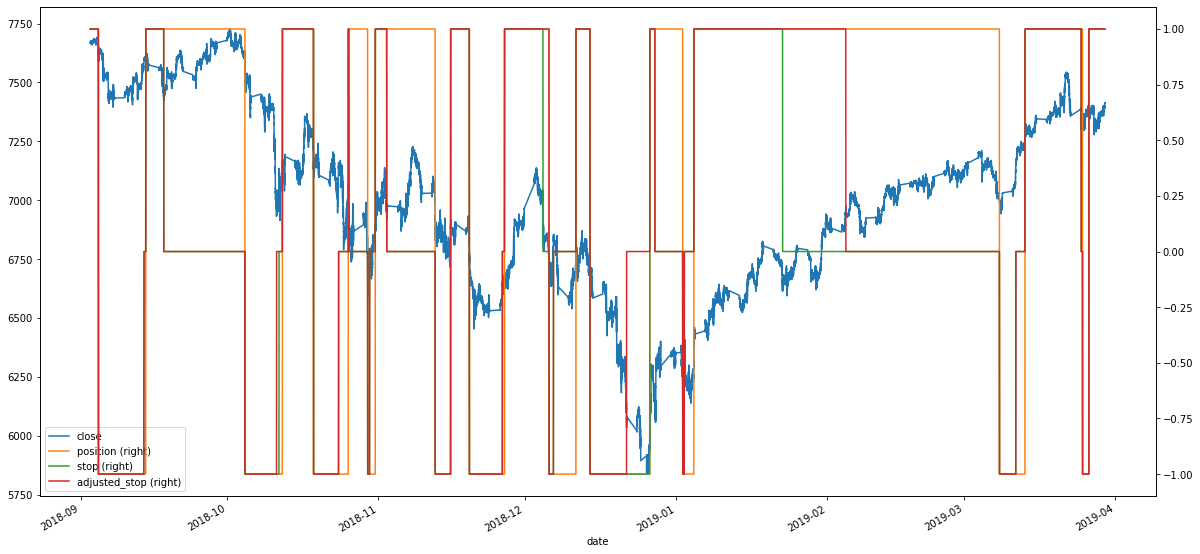

In [7]:
df[['close', 'position', 'stop', 'adjusted_stop']
  ].plot(figsize=(20,10), secondary_y=['position', 'stop', 'adjusted_stop']);

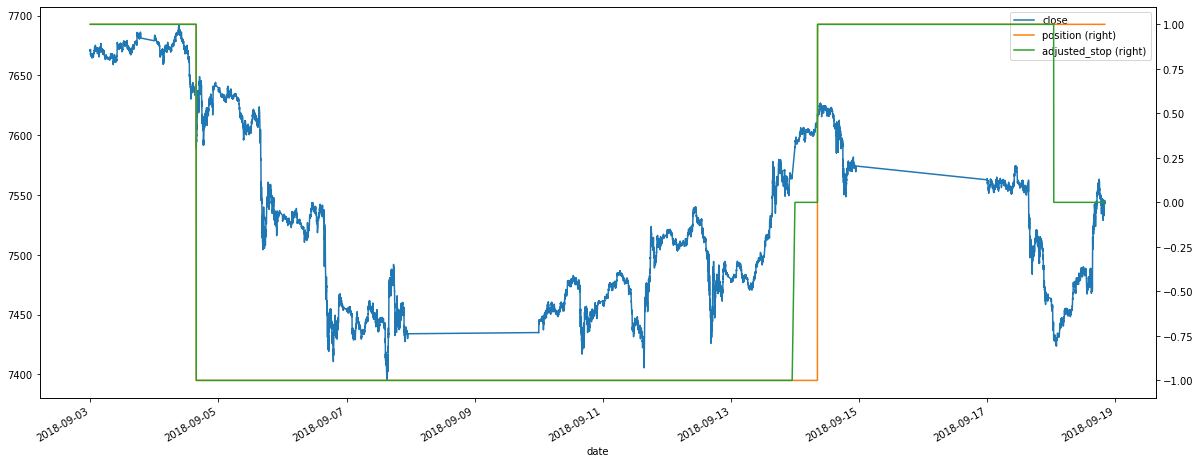

In [8]:
df[['close', 'position', 'adjusted_stop']].iloc[:16000].plot(figsize=(20,8), secondary_y=['position', 'adjusted_stop']);

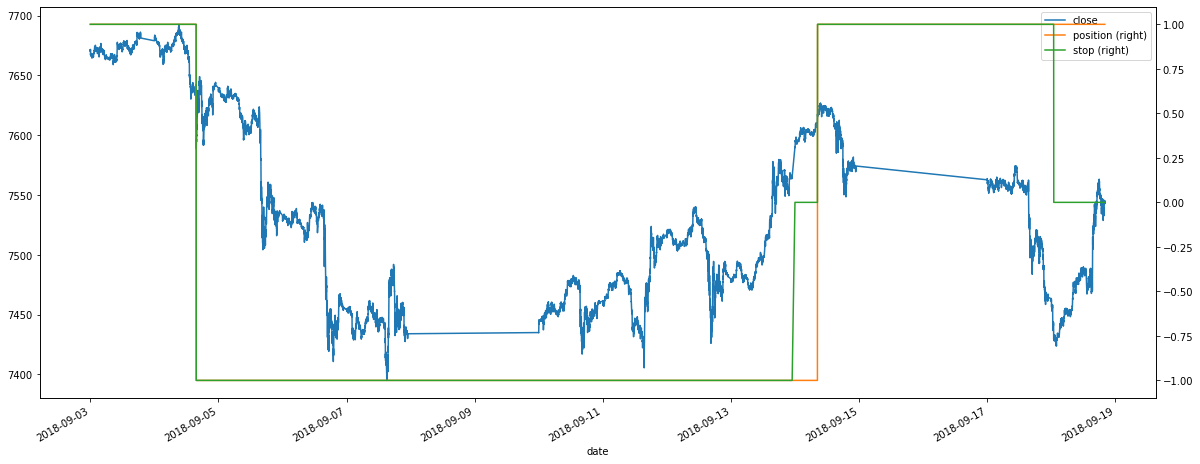

In [9]:
df[['close', 'position', 'stop']].iloc[:16000].plot(figsize=(20,8), secondary_y=['position', 'stop']);